In [28]:
import numpy as np
from qutip import *
from qutip.qip.operations import rx
import scipy as sp
from scipy.optimize import curve_fit,fsolve
from scipy.special import erfc,erf
import os
import sys
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.constants as sc
import scqubits as scq
e_c=(sc.e)**2/2/sc.h/10**(-6)
#parameters to be changed
EJ1=7.3
corr=1#2.62
EJJ=60/corr#JJA junction energy
E1=0.3032002286433497*corr#correct!
N=int(122/corr)
Charge1=0.9177436958045079
gq1=0.07090222363138766
gp1=0.0026783764551955858*2
gpq1=0.27734680023872377*2
'''
#Will's parameters
EJ1=6.2
EJJ=81.6#JJA junction energy
E1=0.3686901660093396#correct!
N=102
Charge1=1.2644130824354534
gq1=0.0976848978022153
gp1=0.006860267400351946
gpq1=0.710383041405096
'''

omega1=np.sqrt(8*E1*EJJ)
EL=EJJ/N
print(EL,omega1)#should be constant (0.5,12.06)
zpf_pp1=((EJJ/8/E1)**(1/4))/np.sqrt(2)
zpf_p=((EL/8/Charge1)**(1/4))/np.sqrt(2)
zpf_x=1/(2*zpf_p)

#Fock Basis
N1=100
a=destroy(N1)
ad=a.dag()
nOp1=-1j*(a-ad)*zpf_p
fOp1=(a+ad)*zpf_x
cosfOp1=((1j*fOp1).expm()+(-1j*fOp1).expm())/2
H0_qub= 4*Charge1*(nOp1**2)+(EJ1)*cosfOp1+0.5*(EL)*(fOp1)**2
qub_energies,qub_states=H0_qub.eigenstates()

#Fluxonium basis
N1=20
H0_new=Qobj(np.matrix([[(np.matrix(qub_states[j].dag())*np.matrix(H0_qub)*np.matrix(qub_states[i]))[0,0] for i in range(N1)] for j in range(N1)]))
nOp_new=Qobj(np.matrix([[(np.matrix(qub_states[j].dag())*np.matrix(nOp1)*np.matrix(qub_states[i]))[0,0] for i in range(N1)] for j in range(N1)]))
fOp_new=Qobj(np.matrix([[(np.matrix(qub_states[j].dag())*np.matrix(fOp1)*np.matrix(qub_states[i]))[0,0] for i in range(N1)] for j in range(N1)]))
qub_energies1,qub_states1=H0_new.eigenstates()
n_new=0*qeye(N1)
for i in range(N1):
    n_new=n_new+i*ket2dm(qub_states1[i])
    
print(qub_energies1)
print([np.abs(expect(n_new,state)) for state in qub_states1])

#parasitic mode
N2=20#truncation error affects the commutation relations!
pa=destroy(N2)
pad=pa.dag()
pn_old=-1j*zpf_pp1*(pa-pad)
pf_old=1/2/zpf_pp1*(pa+pad)
H1_old= 4*E1*(pn_old)**2+0.5*(EJJ)*(pf_old)**2 
par_energies,par_states=H1_old.eigenstates()
print(np.diff(par_energies)[:2])
N2=5
H1_par=Qobj(np.matrix([[(np.matrix(par_states[j].dag())*np.matrix(H1_old)*np.matrix(par_states[i]))[0,0] for i in range(N2)] for j in range(N2)]))
pn=Qobj(np.matrix([[(np.matrix(par_states[j].dag())*np.matrix(pn_old)*np.matrix(par_states[i]))[0,0] for i in range(N2)] for j in range(N2)]))
par_energies,par_states=H1_par.eigenstates()
#the following Hamiltonian could be used with N=3 or 4!
#H1_par=omega1[rho]*(pad*pa+0.5)
#print(np.diff(par_energies))
#print([expect(pad*pa,state) for state in par_states])
#print(pn-pn_old[:N2,:N2])
#assert np.all(np.array(pn)==np.array(pn_old[:N2,:N2]))
#assert np.all(np.array(H1_par)==np.array(H1_old[:N2,:N2]))
#print("The assertion shows that truncation is not an issue as long as we use omega1[rho] defintion for H1_par")
H1=tensor(H0_new,qeye(N2))+tensor(qeye(N1),H1_par)
Hint=gpq1*tensor(nOp_new,pn)#interaction between qubit and the parasitic modes
num_p=tensor(qeye(N1),H1_par/omega1-0.5*qeye(N2))
num_t=tensor(n_new,qeye(N2))



0.4918032786885246 12.06383478620326
[-1.53894102 -1.50875833  4.53580038  5.1255285   9.0636406  11.32333323
 14.38239149 15.96329457 16.14595676 17.34925111 19.55831369 21.12251505
 22.59416968 24.4504127  26.48052369 28.52503096 30.63871813 32.83369895
 35.07911811 37.35674991]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]
[12.06383479 12.06383479]


Q1. Here we link the H1+Hint states with H1 states and print the states which are more hybridized!
0 0 0 (0.9995283647627204+0j) 4.47553307291624 4.492976373618562
0 1 1 (-0.9994768483924674+0j) 4.5041433027792195 4.523159059801105
0 2 2 (-0.9949983447434886+0j) 10.493398068932947 10.567717775658073
0 3 3 (0.993264597640942+0j) 11.055118501017077 11.157445890700815
0 4 4 (0.9899706999091235+0j) 14.974185515398858 15.095557991190471
0 5 7 (-0.9884548547861164+0j) 17.189553665592072 21.995211967854466
0 6 8 (-0.9880117889296536+0j) 20.23500054964235 22.177874150766044
0 7 9 (0.995420498120713+0j) 21.958977475544344 23.381168500680282
0 8 10 (0.9962871834860194+0j) 22.144792439532594 25.59023108748515
0 9 13 (-0.9866616611430364+0j) 23.20082332388759 30.482330091081664
0 10 14 (0.9905870930906214+0j) 25.430043081177345 32.512441084143596
0 11 15 (-0.7198549566633315+0j) 26.856720523135365 34.55694834980943
0 12 17 (0.9687548980344268+0j) 28.400434216108636 38.86561634003275
0 13 21 (0.984

KeyError: (2, 4)

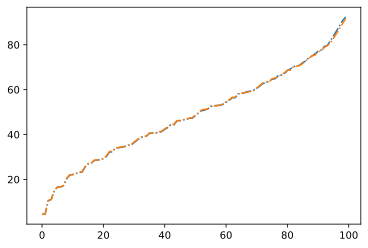

In [29]:
nbar=100
H1=tensor(H0_new,qeye(N2))+tensor(qeye(N1),H1_par)
Hint=gpq1*tensor(nOp_new,pn)#interaction between qubit and the resonator
Ht=2*np.sqrt(nbar)*(gp1*tensor(qeye(N1),pn)+gq1*tensor(nOp_new,qeye(N2)))

#This part is for H1 comparison
initial0=[tensor(qub_states1[0],par_states[0]),tensor(qub_states1[1],par_states[0]),tensor(qub_states1[2],par_states[0]),tensor(qub_states1[3],par_states[0])]
states_final=[[tensor(qub_states1[j],par_states[i]) for j in range(N1)] for i in range(N2)]
exp_i=[expect(H1,i) for i in initial0]
exp_f=[expect(H1,i) for i in states_final]#each row is a parasitic mode level

#This part is for H1+Hint comparison
energy_2,state_2=(H1+Hint).eigenstates()
states_f=[[tensor(qub_states1[j],par_states[i]) for j in range(N1)] for i in range(N2)]
#original basis without coupling to identify the initial states
exp_f1=[]
states_f1=[]
for i in states_f:
    for j in i:
        exp_f1.append(expect(H1,j))
        states_f1.append(j)        
plt.plot(np.sort(np.array(energy_2)),'-.')
plt.plot(np.sort(np.array(exp_f1)),'-.')
index=[]
initial0=states_f1[0:4]
states_final=state_2
exp_i=exp_f1[0:4]#same initial states as before (assuming x=1 does not make things much worse)
exp_f=energy_2#final states
#indexing the states
for i in range(N1*N2):
    c=-1
    e=1
    for j in range(N1*N2):
        #e1=np.abs(np.abs(exp_f1[j])-np.abs(energy_2[i]))
        e1=1-np.abs(state_2[i].overlap(states_f1[j]))**2
        #if e1<e:#energy difference
        if e1<e:# min infidelity
            c=j
            e=e1
#    print(i,c,(int((c)/20),np.mod(c,20)))
    index.append((int((c)/N1),np.mod(c,N1)))

dict_index={}
for i in range(len(index)):
    dict_index[index[i]]=i
print("Q1. Here we link the H1+Hint states with H1 states and print the states which are more hybridized!")
for j in range(N2):
    for i in range(N1):
        state=tensor(qub_states1[i],par_states[j]).unit()
        state1=state_2[dict_index[(j,i)]].unit()
        print(j,i,dict_index[(j,i)],state.overlap(state1), exp_f[dict_index[(j,i)]],exp_f1[dict_index[(j,i)]])        

In [30]:
par_files=np.load('par_new_1.npz')['arr_0']
flux_files=np.load('flux_new_1.npz')['arr_0']
cross_files=np.load('cross_new_1.npz')['arr_0']

In [31]:
def leaked_files(flux_file,par_file,init_state):
    omega_d=np.linspace(8.5,9.5,1000)
    nr=np.linspace(0,50,51)
    Leaked_indices=(flux_file[:,-1]>=init_state+1)
    Decay_indices=(flux_file[:,-1]<=init_state-1)
    leaked_state=[]
    for i in range(100):
        if np.any(Leaked_indices[i*10:(i+1)*10]==True):
            index=i*10+np.argmax(flux_file[i*10:(i+1)*10,-1])
            if index==999:
                break
            if flux_file[index,-1]>flux_file[index+1,-1]:
                leaked_state.append((index,np.round(max(flux_file[i*10:(i+1)*10,-1])),np.round(par_file[index,-1])))
        if  np.any(Decay_indices[i*10:(i+1)*10]==True):
            index=i*10+np.argmin(flux_file[i*10:(i+1)*10,-1])
            if flux_file[index,-1]<flux_file[index+1,-1]:
                leaked_state.append((index,np.round(min(flux_file[i*10:(i+1)*10,-1])),np.round(par_file[index,-1])))
    print("There are",len(leaked_state),"leaked states in this file")
    return leaked_state
#leaked_state_0=leaked_files(flux_files[0],par_files[0],init_state=0)
leaked_state1=leaked_files(flux_files,par_files,init_state=1)
#leaked_state_1=leaked_files(flux_files[1],par_files[0],init_state=1)
#leaked_state_2=leaked_files(flux_files[2],par_files[0],init_state=2)
#print("Leaked states in the first file:",leaked_state_0)
print("Leaked states in the second file:",leaked_state1)
#print("Leaked states in the third file:",leaked_state_2)

There are 7 leaked states in this file
Leaked states in the second file: [(5, 17.0, 0.0), (227, 7.0, 0.0), (488, 12.0, 1.0), (531, 2.0, 1.0), (745, 13.0, 0.0), (817, 5.0, 2.0), (847, 8.0, 0.0)]


In [189]:
omega_d=np.linspace(8.5,9.5,1000)
nr=np.linspace(0,60,61)
en_i=[]
en_j=[]
pq_ex=[]
pp_ex=[]
en_ex=[]
t=0
j=1
leak=leaked_state_1
k=0
omegad=omega_d[leak[k][0]]#the frequency at which the leak occur
"""
assign initial and final states here
"""
states=[dict_index[(0,j)],dict_index[(leak[k][2],leak[k][1])]]
#states=[dict_index[(0,j)]]
#states=[dict_index[(0,j)],dict_index[(0,17)],dict_index[(1,5)]]
for i in states:
    T = 2*np.pi/omegad
    args={'w':omegad}
    psi_old=states_final[i]
    q_ex = np.zeros(len(nr))
    p_ex = np.zeros(len(nr))
    e_ex = np.zeros(len(nr))
    over_ex=np.zeros(len(nr))
    for n,nbar in enumerate(nr):
        Ht=np.sqrt(nbar)*(2*gp1*tensor(qeye(N1),pn)+2*gq1*tensor(nOp_new,qeye(N2)))
        H = [H1+Hint, [Ht, lambda t,args: np.cos(args['w'] * t)]]#2\pi f t
        f_modes_0,f_energies=floquet_modes(H,T, args)
        arg_max=np.argmax([np.abs(psi_old.overlap(f_modes_0[i])) for i in range(N1*N2)])
        psi_t=f_modes_0[arg_max]
        psi_old=psi_t
        q_ex[n] = np.abs(expect(num_t, psi_t))
        p_ex[n] = np.abs(expect(num_p, psi_t))
        e_ex[n] = np.abs(np.mod(f_energies[arg_max],args['w']))#the quasienergies should be using omega and not f!
    pq_ex.append(q_ex)
    en_ex.append(e_ex)
    pp_ex.append(p_ex)

 /opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/qutip/solver/floquet_bwcomp.py: 37

Text(0.5, 0, '$n_r$')

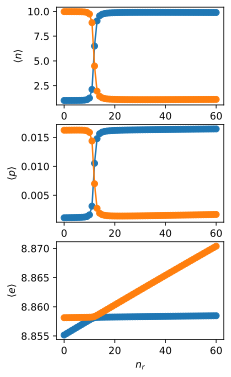

In [190]:
fig,ax=plt.subplots(3,1,figsize=(3,6))
for i in range(len(states)):
    ax[0].plot(nr,pq_ex[i],'-o',label='qubit')
    ax[1].plot(nr,pp_ex[i],'-o',label='parasitic mode')
    ax[2].plot(nr,en_ex[i],'-o',label='quasi-energy')
    #ax[i].set_xlim(40,50)
ax[0].set_ylabel(r"$\langle n \rangle$")
ax[1].set_ylabel(r"$\langle p \rangle$")
ax[2].set_ylabel(r"$\langle e \rangle$")
ax[2].set_xlabel(r"$n_r$")

In [ ]:
#Save the data
"""
name_0='Will_Trans_'+str(j)+'_'+str(k)+'.npz'
name_1='Will_States_'+str(j)+'_'+str(k)+'.npz'
name_2='Will_Data_'+str(j)+'_'+str(k)+'.npz'
gap=min(np.abs(en_ex[0]-en_ex[1]))
threshold=np.argmin(np.abs(en_ex[0]-en_ex[1]))
Trans_array=[pq_ex,pp_ex,en_ex]
np.savez(name_0,Trans_array)
np.savez(name_1,[index[state] for state in states])
np.savez(name_2,[omegad,threshold,gap])
print(name_0,name_1,name_2)
"""

Will_Trans_1_0.npz Will_States_1_0.npz Will_Data_1_0.npz


In [192]:
pq_ex1=np.load(name_0)['arr_0'][0]
pp_ex1=np.load(name_0)['arr_0'][1]
en_ex1=np.load(name_0)['arr_0'][2]
gap1=min(np.abs(en_ex1[0]-en_ex1[1]))
threshold1=np.argmin(np.abs(en_ex1[0]-en_ex1[1]))
print(omegad,threshold1,gap1)
print(np.load(name_1)['arr_0'])
print(np.load(name_2)['arr_0'])

9.387887887887889 12 0.0002082024258456272
[[ 0  1]
 [ 0 10]]
[9.38788789e+00 1.20000000e+01 2.08202426e-04]


In [ ]:
#Stark shifted eigenenergies (this is also computed using 20-by-5 Hilbert space)
j=2
leak=leaked_state_2
k=6
omegad=omega_d[leak[k][0]]#the frequency at which the leak occur
states=np.load('States_'+str(j)+'_'+str(k)+'.npz')['arr_0']
stark_trans=[]
for l in range(len(states)):
    stark_en=[]    
    for n,nbar in enumerate(nr):
        i=dict_index[(states[l][0],states[l][1])]
        stark_en.append(np.mod(exp_f[i]+stark(i,nbar,omegad,0)+stark(i,nbar,omegad,1),omegad))
    stark_trans.append(stark_en)
np.savez(name_3,stark_trans) 

In [10]:
#LZ values
#correct version with N2=3  (only these simulations use a Hilbert space of 20-by-3 instead of 20-by-5)
omega_d=np.linspace(8.5,9.5,1000)
omegad=omega_d[531]
T=2*np.pi/omegad
qub=[dict_index[(0,1)],dict_index[(1,2)]]  
over1_ex01=[]
over1_ex11=[]

LZ1=[]
psi_0=states_final[qub[0]]
psi_1=states_final[qub[1]]

for k in np.geomspace(0.00001,0.1,100):
    #tlist=-(2/k)*np.log(1-np.sqrt(nr1/50))#this is what changes every time, unlike our case of t=T
    args={'w':omegad,'k':k}
    tlist=np.array(np.linspace(0,int(10/k/T)*T+T,25))
    nr1=50*(1-np.exp(-k*tlist/2))**2
    Ht=(2*gp1*tensor(qeye(N1),pn)+2*gq1*tensor(nOp_new,qeye(N2)))
    H = [H1+Hint, [Ht, lambda t,args:np.cos(args['w']*t)*np.sqrt(50)*(1-np.exp(-args['k']*t/2))]]
    psi_tf=sesolve(H,psi_0,tlist,options=Options(nsteps=100000000),args={'w':omegad,'k':k}).states[-1]
    en_ex=[]
    for i in range(2):
        psi_old=states_final[qub[i]]
        e_ex = np.zeros(len(nr1))
        for n,t in enumerate(tlist):
            Ht=np.sqrt(nr1[n])*(2*gp1*tensor(qeye(N1),pn)+2*gq1*tensor(nOp_new,qeye(N2)))
            H = [H1+Hint, [Ht, lambda t,args: np.cos(args['w'] * t)]]#2\pi f t
            f_modes_0,f_energies=floquet_modes(H,T, args)
            arg_max=np.argmax([np.abs(psi_old.overlap(f_modes_0[j])) for j in range(N2*N1)])
            psi_t=f_modes_0[arg_max]
            psi_old=psi_t
            e_ex[n] = np.abs(np.mod(f_energies[arg_max],args['w']))#the quasienergies should be using omega and not f!
        if i==0:
            psi_00=psi_old
        else:
            psi_11=psi_old
        en_ex.append(e_ex)

    over1_ex01.append(np.abs(psi_tf.overlap(psi_00))**2)#fidelity with the original floquet mode
    over1_ex11.append(np.abs(psi_tf.overlap(psi_11))**2)#fidelity with the original floquet mode    
    print(over1_ex01[-1],over1_ex11[-1])

    ei=np.array(en_ex)[0]
    ef=np.array(en_ex)[1]
    n=np.sqrt(np.array(nr1))
    t=np.array(tlist)

    #first derivative
    d_ef=np.diff(ef,1)
    d_n=np.diff(n,1)
    d_t=np.diff(t,1)
    ef_first=d_ef/d_n

    #second derivative
    n_first=0.5*(n[:-1]+n[1:])
    d_ef_first=np.diff(ef_first,1)
    d_n_first=np.diff(n_first,1)
    min_index=np.argmin(np.abs(np.array(ef)-np.array(ei)))
    if min_index<len(d_ef_first) and min_index!=0:
        nfirst=np.abs(d_n/d_t)[min_index]
        ef_second=np.abs(d_ef_first[min_index]/d_n_first[min_index])
        Delta=min(np.abs(np.array(ef)-np.array(ei)))
        v=np.sqrt(2*Delta*ef_second)*nfirst #v is in units of f per second
        P=np.exp(-np.pi*(Delta**2)/(2*v))#delta/v is in sec and Delta is in sec^(-1)
        LZ1.append(1-P)
    else:
        LZ1.append(0)
        print("no avoided crossing")
    print(LZ1[-1])
    

0.9999232723279678 7.680844643155608e-05
1.0
0.9994807784550737 0.0005189866523396805
1.0
0.9997777784754898 0.00022208377131281473
1.0
0.9998168828535026 0.00018298428909946504
1.0
0.999936888719632 6.307941557185413e-05
1.0
0.9999345368534134 6.544862937440666e-05
1.0
0.999866065893335 0.00013402750586363532
1.0
0.9996720353766793 0.00032814668767825036
1.0
0.9999524395187792 4.752953377381676e-05
1.0
0.9999357877051048 6.414004705230706e-05
0.9999999999999989
0.9997976038554033 0.00020250408715325363
0.9999999999999755
0.9999433998744858 5.666594137387649e-05
0.9999999999996021
0.9999933969203363 6.6090020871437595e-06
0.9999999999949724
0.9998417550813816 0.00015822670359812228
0.9999999999492925
0.9998012339565759 0.00019864679154419517
0.9999999995834699
0.9998240131493794 0.00017585126617684777
0.9999999971623768
0.9999276485928896 7.234477804274935e-05
0.9999999836961201
0.9999858759971437 1.4090201315536475e-05
0.9999999198104031
0.9998942819327418 0.00010562041858236864
0.999

In [11]:
index=""
np.save("LZ1"+index+".npy",LZ1)
np.save("state_i"+index+".npy",over1_ex01)
np.save("state_f"+index+".npy",over1_ex11)
'''

LZ1=np.load("LZ1.npy")
over1_ex01=np.load("state_i.npy")
over1_ex11=np.load("state_f.npy")

plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),1-np.array(LZ1),'-',linewidth=3,color="mediumaquamarine",label=r"LZ: $1-e^{-\pi\Delta_{ac}^2/2v_{ac}}$")#0 to 11
plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),1-np.array(over1_ex01),'o',color="maroon",label=r"$1-\langle i_{t_f}|U(t_f)|i\rangle$")# 3 to 4
plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),np.array(over1_ex11),'--',linewidth=3,color="blue",label=r"$\langle f_{t_f}|U(t_f)|i\rangle$")# 3 to 4
#plt.xscale('log')
plt.xlabel(r"$\kappa$[in MHz]")
plt.ylabel("Probability")
plt.legend()
plt.savefig("Trans_Prob.pdf")
plt.show()
'''

'\n\nLZ1=np.load("LZ1.npy")\nover1_ex01=np.load("state_i.npy")\nover1_ex11=np.load("state_f.npy")\n\nplt.plot(np.geomspace(0.0001,0.1,100)*(10**3),1-np.array(LZ1),\'-\',linewidth=3,color="mediumaquamarine",label=r"LZ: $1-e^{-\\pi\\Delta_{ac}^2/2v_{ac}}$")#0 to 11\nplt.plot(np.geomspace(0.0001,0.1,100)*(10**3),1-np.array(over1_ex01),\'o\',color="maroon",label=r"$1-\\langle i_{t_f}|U(t_f)|i\rangle$")# 3 to 4\nplt.plot(np.geomspace(0.0001,0.1,100)*(10**3),np.array(over1_ex11),\'--\',linewidth=3,color="blue",label=r"$\\langle f_{t_f}|U(t_f)|i\rangle$")# 3 to 4\n#plt.xscale(\'log\')\nplt.xlabel(r"$\\kappa$[in MHz]")\nplt.ylabel("Probability")\nplt.legend()\nplt.savefig("Trans_Prob.pdf")\nplt.show()\n'

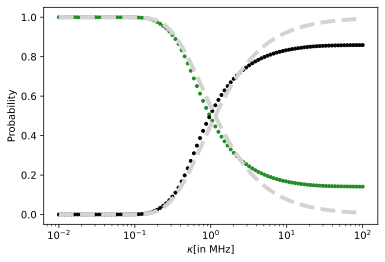

In [12]:
'''
LZ2=np.load("LZ1.npy")
over1_ex02=np.load("state_i.npy")
over1_ex12=np.load("state_f.npy")
'''
plt.plot(np.geomspace(0.00001,0.1,100)*(10**3),np.array(over1_ex01),'.',linewidth=4,color="forestgreen",label=r"$1-\langle i_{t_f}|U(t_f)|i\rangle$")# 3 to 4
plt.plot(np.geomspace(0.00001,0.1,100)*(10**3),np.array(over1_ex11),'.',linewidth=4,color="black",label=r"$\langle f_{t_f}|U(t_f)|i\rangle$")# 3 to 4
plt.plot(np.geomspace(0.00001,0.1,100)*(10**3),np.array(LZ1),'--',linewidth=4,color="lightgray",label=r"$1-\langle i_{t_f}|U(t_f)|i\rangle$")# 3 to 4
plt.plot(np.geomspace(0.00001,0.1,100)*(10**3),1-np.array(LZ1),'--',linewidth=4,color="lightgray",label=r"$\langle f_{t_f}|U(t_f)|i\rangle$")# 3 to 4
#plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),np.array(over1_ex02),'-',linewidth=1,color="mediumaquamarine",label=r"$1-\langle i_{t_f}|U(t_f)|i\rangle$")# 3 to 4
#plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),np.array(over1_ex12),'-',linewidth=1,color="mediumaquamarine",label=r"$\langle f_{t_f}|U(t_f)|i\rangle$")# 3 to 4
#plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),1-np.array(LZ2),'--',linewidth=1,color="mediumaquamarine",label=r"LZ: $1-e^{-\pi\Delta_{ac}^2/2v_{ac}}$")#0 to 11
#plt.plot(np.geomspace(0.0001,0.1,100)*(10**3),np.array(LZ2),'--',linewidth=1,color="mediumaquamarine",label=r"LZ: $1-e^{-\pi\Delta_{ac}^2/2v_{ac}}$")#0 to 11
plt.xscale('log')
#plt.xlim(1,100)
plt.xlabel(r"$\kappa$[in MHz]")
plt.ylabel("Probability")
#plt.xlim(0,5)
#plt.legend()
#plt.savefig("Trans_Prob.pdf")
plt.show()

In [32]:
#Change to N2=5 again!
def Trans_Array(Delta):
    wr1=np.linspace(1,12,1000)
    x=np.linspace(1,4,4)#change to 0,9,10 for second figure
    y=np.linspace(1,2,3)
    #print(x)
    b=[x[-1],y[-1],-1]
    Trans_=[]
    Err=0.011#50 MHz difference in frequency
    for w in wr1:
        Trans=[]
        flag=False
        for k1,k in enumerate(Delta):
            a=[x[-1],y[-1],-1]
            for i in x:
                if np.abs(i*w-k)<Err and (i!=0 or j!=0):
                    if (a[0]+a[1])>(i+j):
                        a=[i,index[k1][0],index[k1][1]]
            if a[2]!=b[2]:
                Trans.append(a)
        if Trans!=[]:
            Trans_.append([w,np.array(Trans)])         
    return Trans_
Delta0=[exp_f[i]-exp_f1[0] for i in range(N1*N2)]
Delta1=[exp_f[i]-exp_f1[1] for i in range(N1*N2)]
Delta2=[exp_f[i]-exp_f1[2] for i in range(N1*N2)]
Delta3=[exp_f[i]-exp_f1[3] for i in range(N1*N2)]
np.savez("Trans_0.npz",np.array(Trans_Array(Delta0),dtype=object))
np.savez("Trans_1.npz",np.array(Trans_Array(Delta1),dtype=object))
np.savez("Trans_2.npz",np.array(Trans_Array(Delta2),dtype=object))

In [26]:
#Stark_shift
def charge_drive(i,j,k):
    if k==0:
        return (np.abs(((Qobj(states_final[j]).dag())*tensor(nOp_new,qeye(N2))*Qobj(states_final[i]))[0,0]))**2
    if k==1:
        return (np.abs(((Qobj(states_final[j]).dag())*tensor(qeye(N1),pn)*Qobj(states_final[i]))[0,0]))**2
    
def stark(i,nr,omegad,k):#k indicates qubit and paraisitc mode
    s=0
    for f in range(len(exp_f)):
        s=s+(exp_f[f]-exp_f[i])*charge_drive(i,f,k)/(omegad**2-(exp_f[f]-exp_f[i])**2)
    if k==0:
        g=gq1
    if k==1:
        g=gp1
    return 2*nr*s*(g**2)


i=2
nr=np.linspace(0,50,51)
stark_arr=[]
for omegad in omega_d:
    en=[]
    for nbar in nr:
        en.append(stark(i,nbar,omegad,0)+stark(i,nbar,omegad,1))
    stark_arr.append(en)
name='Stark_'+str(i)+'.npz'
np.savez(name,stark_arr)